# Variational Autoencoder

In this assignment we will use the code from the Chollet textbook to build our own VAE model

The dataset is provided in '../resource/asnlib/publicdata/dataset/'. This is a set of images of famous people.

The goal is to see what output we can generate using a VAE on this dataset.

Also see the source code from Chollet that uses the MNIST dataset; code below is adapted from here:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.backend.tensorflow_backend import set_session

import numpy as np
# import os
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.callbacks import ModelCheckpoint

from scipy.misc import imresize

import matplotlib.pyplot as plt

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary

In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

## Load the data

In [4]:
PATH = '..//resource/asnlib/publicdata/dataset/'
file_base_names = list(os.walk(PATH))[0][2]

In [5]:
filenames = list(os.path.join(PATH, x) for x in file_base_names)

In [6]:
filenames[:10]

['..//resource/asnlib/publicdata/dataset/Andy_Roddick_0005.jpg',
 '..//resource/asnlib/publicdata/dataset/Paul_ONeill_0003.jpg',
 '..//resource/asnlib/publicdata/dataset/Aly_Wagner_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/John_Howard_0008.jpg',
 '..//resource/asnlib/publicdata/dataset/Colin_Powell_0102.jpg',
 '..//resource/asnlib/publicdata/dataset/Scott_Fawell_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/Ben_Curtis_0002.jpg',
 '..//resource/asnlib/publicdata/dataset/Peter_Sejna_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/Venus_Williams_0008.jpg',
 '..//resource/asnlib/publicdata/dataset/Larry_Lucchino_0002.jpg']

# Load images into numpy array

In [7]:
imagedata_list = []
for file in filenames:
    ar = np.array(Image.open(file))
    imagedata_list.append(ar)

In [8]:
data = np.stack(imagedata_list)

In [9]:
data.shape

(1203, 250, 250, 3)

It looks like we have just over 1200 images. The size of each image is 250x250, let's take a look and see if we can potentially downsample to 125x125 to speed up the VAE.

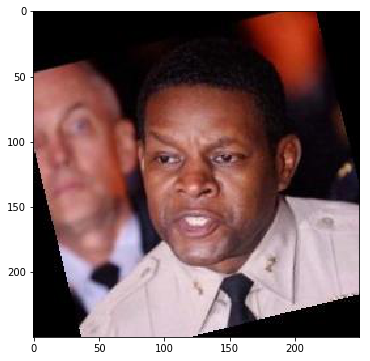

In [10]:
# Look at a random image
idx = np.random.choice(data.shape[0])
plt.figure(figsize=(6, 6))
plt.imshow(data[idx])
plt.show()

We can use the 'imresize' function from scipy.misc to downsample the image. Let's run a quick test.

In [11]:
test = imresize(data[idx],0.5)

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [12]:
test.shape

(125, 125, 3)

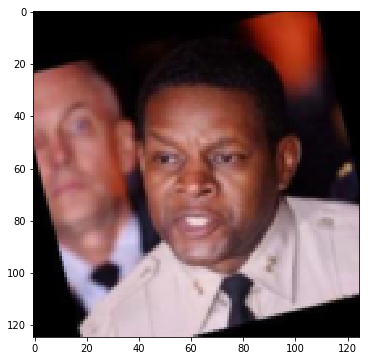

In [13]:
# Look at an image
plt.figure(figsize=(6, 6))
plt.imshow(test)
plt.show()

The image looks reasonable, despite having 1/4 the number of pixels. Let's go ahead and downsample the entire set.

In [14]:
imagedata_list = []
for image in data:
    ar = imresize(image,0.5)
    imagedata_list.append(ar)

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [15]:
data = np.stack(imagedata_list)

In [16]:
data.shape

(1203, 125, 125, 3)

Now, we have the same size data set, but each image is 125x125.

From here, let's build our encoder.

In [19]:
img_size = 125
img_shape = (img_size, img_size, 3)
batch_size = 32  # 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)

print(K.int_shape(x))

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)

print(K.int_shape(x))

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

(None, 63, 63, 64)
(None, 32, 32, 64)


Note that the convolutions reduce the size of the feature map from 125x125 to a final dimension of 32x32, with 64 filters. The final step is to produce the mean and variance of the latent space from the input image via dense layers.

In [20]:
shape_before_flattening

(None, 32, 32, 64)

In [21]:
16*16*64, 14*14*64

(16384, 12544)

We'll do our sampling in the latent space via a special 'Lambda' layer, which is Keras' general layer for housing a function.

In [22]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Once the image is encoded and the latent space parameters have been generated, we feed the result to an input layer and upsample to the correct feature map size (before we flattened our feature map for the parameter generation).

In [23]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

print(K.int_shape(x))

(None, 32, 32, 64)


## Below is a sample decoding stack of deconvolutional layers. 

It is different from the one in the original Chollet code because the image sizes are different.

### TODO (optional): Experiment with the decoding network architecture; try to improve it.

In [24]:
# We then apply then reverse operation to the initial
# stack of convolution layers: `Conv2DTranspose` layers
# with corresponding parameters.

print(K.int_shape(x))

x = layers.Conv2DTranspose(64, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

print(K.int_shape(x))

x = layers.Conv2D(64, 3,
                  padding='same', activation='sigmoid')(x)

x = layers.Conv2DTranspose(64, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

# The size has become too big (the feature map has a shape of 128 instead of 125). 
# Several different techniques were used to reduce the size, the best seemed to be
# using two valid convolutions in order to keep the filter size down (using a filter 
# larger than 3x3 made the resulting images too blurry), and also stepping down from
# 64 filters to 32 and finally to 3. Another attempt was to use a single convolution
# to go from 128x128x64 to 125x125x3, but the larger filter size and step reduction in
# filters produced lower quality images in the latent space.

print(K.int_shape(x))

x = layers.Conv2D(32, 3,
                  padding='valid', activation='sigmoid')(x)

print(K.int_shape(x))

x = layers.Conv2D(3, 2,
                  padding='valid', activation='sigmoid')(x)

print(K.int_shape(x))

# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

(None, 32, 32, 64)
(None, 64, 64, 64)
(None, 128, 128, 64)
(None, 126, 126, 32)
(None, 125, 125, 3)


Because we have two loss functions (reconstruction and regularization), we need to implement our loss via a custom layer. 

In [25]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

Finally, we're ready to build and train our model.

In [26]:
vae = Model(input_img, y)
#vae.compile(optimizer='rmsprop', loss=None)
optimizer = keras.optimizers.Adam(lr=0.001)
vae.compile(optimizer=optimizer, loss=None)
vae.summary()

# Train the VAE on MNIST digits
train, test = train_test_split(data)

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 125, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 63, 63, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 63, 63, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


In [27]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [28]:
vae.fit(x=train, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(test, None),
        callbacks=callbacks_list)

Train on 902 samples, validate on 301 samples
Epoch 1/20
902/902 [==============================] - 135s 149ms/step - loss: 0.6768 - val_loss: 0.6555

Epoch 00001: saving model to weights-improvement-01-0.66.hdf5
Epoch 2/20
902/902 [==============================] - 136s 150ms/step - loss: 0.6556 - val_loss: 0.6529

Epoch 00002: saving model to weights-improvement-02-0.65.hdf5
Epoch 3/20
902/902 [==============================] - 137s 152ms/step - loss: 0.6549 - val_loss: 0.6518

Epoch 00003: saving model to weights-improvement-03-0.65.hdf5
Epoch 4/20
902/902 [==============================] - 137s 152ms/step - loss: 0.6479 - val_loss: 0.6437

Epoch 00004: saving model to weights-improvement-04-0.64.hdf5
Epoch 5/20
902/902 [==============================] - 137s 152ms/step - loss: 0.6389 - val_loss: 0.6275

Epoch 00005: saving model to weights-improvement-05-0.63.hdf5
Epoch 6/20
902/902 [==============================] - 137s 152ms/step - loss: 0.6167 - val_loss: 0.6079

Epoch 00006: s

To test our VAE, we'll sample the latent space (a Gaussian) from the 5th to the 95th percentile in each direction and decode the image contained at that point.

-1.6448536269514729
-0.984234960446325
-0.5977601260424786
-0.2858408748811657
-1.3914582123358836e-16
0.2858408748811657
0.5977601260424784
0.9842349604463245
1.6448536269514722


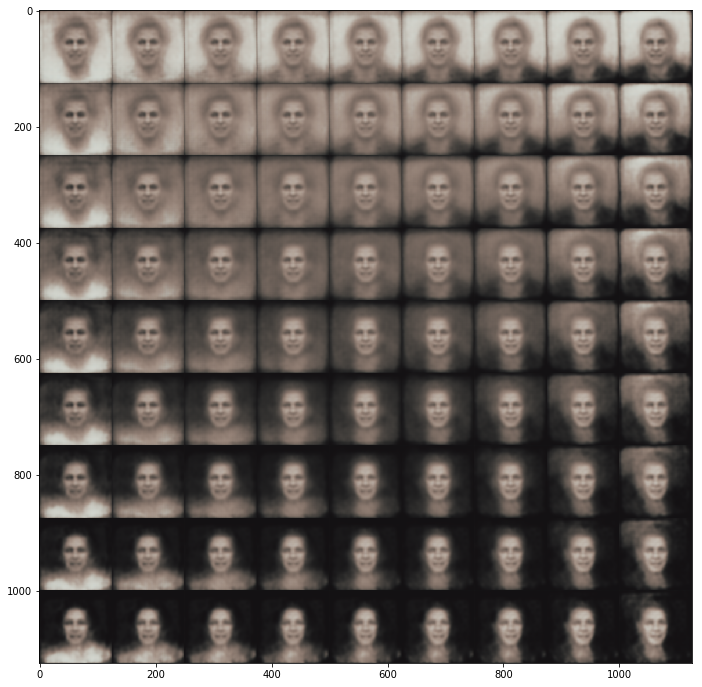

In [29]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 9  # figure with 15x15 digits
digit_size = img_size
figure = np.zeros((digit_size * n, digit_size * n, 3))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    print(yi)
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

## Question 1
Examine the results. What does the x-dimension of the latent space represent? What does the y-dimension represent?

The results are very interesting. Each image is of a 'new' face that was not part of the training set. The x-dimension of the latent space seems to correspond to a change in clothing. Figures on the left are wearing lighter colored clothes, while figures on the right are wearing darker colored clothes. There is a smooth gradient in color as you move left to right. In addition, it also seems that hair length and/or the amount of hair the figure has decreases as you move left to right.

## Question 2
What does the y-dimension represent?

While the x-dimension relates to clothing and hair, the y-dimension of the latent space seems to correspond to a change in gender. Figures along the top row are more masculine in appearance, and as you move down, the images become more feminine in appearance.

## Question 3
Comment on the results. How did they turn out? Did anything surprise you?

I think the results were very promising overall, the images generated by the latent space show quite a bit of variation as you sample different points. The space appears to be continuous, as images gently transition as you move along each axis.

There were some definite learning points along the way. For example, I started with a subset of the images, but no output images were discernable until around 200 training images were used. From there, the clarity of the images increased with the number of training samples.

In addition, there was quite a bit of experimenting with the network architecture, and the results were somewhat surprising. For example, a shallower architecture (in this case only reducing the feature maps from 125x125 63x63) actually produced the sharpest images from the decoder, but all of the faces looked the same within the latent space. On the other hand, deeper archictectures (reducing the feature map from 125x125 to 16x16) produced the blurriest images, but there was much greater variety between the faces within the latent space. In the end, I settled on a compromise, creating a network with medium depth (reducing the feature maps from 125x125 to 64x64) in order to produce images that were only slightly blurry, and with a decent amount of variation throughout the latent space. The deeper network could be used if more training images were available (1200 is not a very large image data set).

The final hurdle I had to overcome was determining the best way to reduce the upsampled feature map to the correct size (after upsampling, the feature map ends up being 128x128x64, rather than 125x125x3). I tried various techniques: using a single valid convultion, using to two valid convolutions, and using one valid and one same convolution. In the end, I found that using a large filter size (anything larger than a 3x3) resulted in images that were too blurry. This makes sense, as you're sliding a larger window over the feature map and washing out finer details. Also, using a single valid convolution to get the proper size was too big of a jump in terms of a large filter size (4x4) and an immediate reduction from 64 to 3 filters. As with the architecture, in the end I reach a compromise, using two valid convolutions with smaller filter sizes (3x3 and 2x2), and also stepping down in filter size from 64 to 32 to 3.

Overall, I thought this exercise was really interesting. I love the theory behind VAEs and it was great to see a real example.